In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
import torch
import time
import math
from sklearn.metrics import accuracy_score

In [2]:
def encod_map(x):
    e = np.zeros(16).astype(int)
    index = int("".join(str(y) for y in x), 2)
    e[index] = 1
    return  e

In [3]:
X = np.random.randint(1,10,size=(100000,4))%2
x_train,x_val = train_test_split(X,test_size=0.2,random_state=4)

In [4]:
def one_hot_vec(x_train,x_val):
    x_new_train = np.zeros((x_train.shape[0],2**(x_train.shape[1])))
    for i in range(x_train.shape[0]):
        x_new_train[i] = encod_map(x_train[i])

    x_new_val = np.zeros((x_val.shape[0],2**(x_val.shape[1])))
    for i in range(x_val.shape[0]):
        x_new_val[i] = encod_map(x_val[i])
    # print(x_new_train[:2])
    # print(np.where(np.sum(x_new_train,axis=1) != 1))
    # print(np.where(np.sum(x_new_val,axis=1) != 1))

    x_torch_train = torch.from_numpy(x_new_train).float()
    x_torch_test = torch.from_numpy(x_new_val).float()
    
    return x_torch_train,x_torch_test

In [5]:
x_torch_train,x_torch_val = one_hot_vec(x_train,x_val)

In [6]:
batch = 1000
train_loader = DataLoader(x_torch_train,batch_size = batch,shuffle = True)
val_loader = DataLoader(x_torch_val,batch_size = batch,shuffle = False)

In [7]:
varience = 1

In [8]:
class hd3_VE(nn.Module):
    def __init__(self, in_sz = 16, out_sz = 16, layers=[16,7]):
        super().__init__()
        self.relu = nn.ReLU()
        self.encoder = nn.Sequential(
            nn.Linear(in_sz,layers[0]),
            self.relu,
            nn.Linear(layers[0],layers[1]),
            # self.relu,
            # nn.Linear(layers[1],layers[2]),
            # self.relu
            # nn.Linear(layers[2],layers[3])
        )
        self.decoder = nn.Sequential(
            # nn.Linear(layers[3],layers[2]),
            # self.relu,
            # nn.Linear(layers[2],layers[1]),
            # self.relu,
            nn.Linear(layers[1],layers[0]),
            self.relu,
            nn.Linear(layers[0],out_sz),
            nn.LogSoftmax()
        )
        # self.var = None
        # self.encoded_sig = None
        # self.normalized_sig = None
        # self.corr_sig = None
        # self.decoded_sig = None
        # self.EbNochannel = None

    def encode_data(self,X):
        return self.encoder(X)
        
    def decode_data(self,X):
        return self.decoder(X)
    
    # def used_in_test(self,X,var = 0):
    #     self.var = var
    #     encoded_sig = self.encoder(X)
    #     decoded_sig = self.decoder(encoded_sig)
    #     return decoded_sig
    
    def forward(self,X,var = varience):
        # self.var = var
        encoded_sig = self.encoder(X)
        normalized_sig = self.normalize(encoded_sig)
        corr_sig = self.add_noise(normalized_sig,var)
        decoded_sig = self.decoder(corr_sig)
        return decoded_sig
    
    def normalize(self,sig):
        norm = torch.zeros(sig.size()[0],1)
        norm[:,0] = (torch.linalg.norm(sig,dim = 1))
        norm = norm.expand(-1,sig.size()[1])
        sig = torch.div(sig,norm)
        sig = sig * 7
        return sig
    
    def add_noise(self,msg,var = varience):
        msg = msg + (var ** 0.5) * torch.randn(*msg.size())
        return msg
    
    def EbNoChannel(self,var = varience):
        k = 4
        n = 7
        R = k/n
        Eb = 7
        No = var
        self.channel = Eb/No + 10 * math.log10(R)
    

#### Skip

In [9]:
model = hd3_VE()
model

hd3_VE(
  (relu): ReLU()
  (encoder): Sequential(
    (0): Linear(in_features=16, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=7, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=7, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): LogSoftmax(dim=None)
  )
)

In [10]:
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [11]:
torch.autograd.set_detect_anomaly(True)
start_time = time.time()
epochs = 10
train_losses = []
val_losses = []
accuracy = {}

fp = open('3hd_AE.txt',"w")
for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    for b,x in enumerate(train_loader):

        b+=1
        
        y_pred = model(x,var = varience)

        # assert torch.count_nonzero(y_pred) != 16000.0, print(torch.count_nonzero(y_pred))

        pred_index = torch.argmax(y_pred,dim = 1)
        actual_index = torch.argmax(x,dim = 1)

        # loss = criterion(torch.log(y_pred), actual_index)
        loss = criterion((y_pred), actual_index)

        batch_corr = torch.sum(pred_index == actual_index)
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if b%8 == 0:
            fp.write(f'epoch: {i}  batch: {b} [{batch*b:6}/{x_train.shape[0]}]  loss: {loss.item():10.8f}  accuracy: {trn_corr.item()*100/(batch*b):7.3f}%')
                
            fp.write('\n')
            
    accuracy[i] = trn_corr.item()*100/(batch*b)
    train_losses.append(loss.item())

    with torch.no_grad():
        for val in val_loader:

            y_val = model(val,var = varience)

            pred_val_index = torch.argmax(y_val,dim = 1)
            actual_val_index = torch.argmax(val,dim = 1)
            
            tst_corr += torch.sum(pred_val_index == actual_val_index)
   
        # loss = criterion(torch.log(y_val), actual_val_index)
        loss = criterion((y_val), actual_val_index)
        val_losses.append(loss.item())

fp.close()
fp = open('3hd_AE.txt',"a")
fp.write(f'\nDuration: {time.time() - start_time:.0f} seconds')
fp.close()

/home/lohith/chida/environments/basic/lib/python3.7/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)
/home/lohith/chida/environments/basic/lib/python3.7/site-packages/torch/autograd/__init__.py:175: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 9000). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  allow_unreachable=True, accumulate_grad=True)  # Calls into the C++ engine to run the backward pass


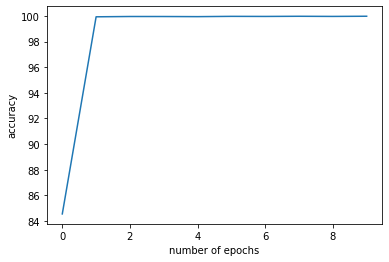

In [12]:
key,value = zip(*sorted(accuracy.items()))
plt.xlabel('number of epochs')
plt.ylabel("accuracy")
plt.plot(key,value);

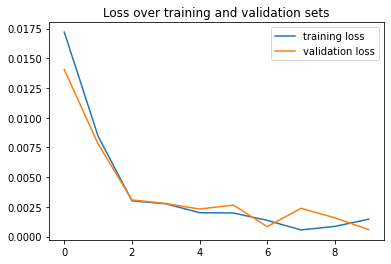

In [13]:
plt.plot(train_losses, label='training loss')
plt.plot(val_losses, label='validation loss')
plt.title('Loss over training and validation sets')
plt.legend();

#### till here

In [14]:
total_data = torch.cat((x_torch_train,x_torch_val))
big_train = DataLoader(total_data,batch_size = batch)

In [15]:
model.eval()
with torch.no_grad():
    corr_batch = 0
    for set in big_train:
        y_val = model(set,var = varience)
        # print(y_val.size())
        predicted_tot_train_index = torch.argmax(y_val,dim = 1)
        actual_tot_train_index = torch.argmax(set,dim = 1)
        
        corr_batch += torch.sum(predicted_tot_train_index == actual_tot_train_index)
        # print(accuracy_score(predicted_new_test,check))
    print(1 - corr_batch/total_data.shape[0])
    print(corr_batch)

tensor(0.0002)
tensor(99975)


In [16]:
block = np.random.randint(1,10,size = (100000,4))%2
map_block = np.zeros((block.shape[0],2**(block.shape[1])))
for i in range(block.shape[0]):
    map_block[i] = encod_map(block[i])
test = torch.from_numpy(map_block).float()
print(test.shape)
test_loader = DataLoader(test,batch_size = 100000)

torch.Size([100000, 16])


In [17]:
model.eval()
with torch.no_grad():
    corr = 0.0
    for test_samp in test_loader:
        # print(type(test_samp))
        y_test = model.encode_data(test_samp)
        # print(y_test)
        # print(y_test.size())
        # print(torch.linalg.norm(y_test,dim = 1))
        y_test = model.normalize(y_test)
        # print(y_test)
        # print(torch.linalg.norm(y_test,dim = 1))
        y_test = model.add_noise(y_test,var = varience)
        # print(y_test)
        y_test = model.decode_data(y_test)
        # print(y_test)
        # print(y_val.size())
        predicted_test_index = torch.argmax(y_test,dim = 1)
        # print(predicted_test_index)
        actual_test_index = torch.argmax(test_samp,dim = 1)
        corr += torch.sum(predicted_test_index == actual_test_index)
        # print(accuracy_score(predicted_test_index,actual_test_index))
    print(1 - corr/test.size()[0])
    print(corr)

tensor(0.0001)
tensor(99986.)


In [18]:
var_ls = np.linspace(1,10,20)

In [19]:
model.eval()
with torch.no_grad():
    bler = {}
    for samp_var in var_ls:
        corr = 0.0
        for test_samp in test_loader:
            # print(type(test_samp))
            y_test = model.encode_data(test_samp)
            # print(y_test)
            # print(y_test.size())
            # print(torch.linalg.norm(y_test,dim = 1))
            y_test = model.normalize(y_test)
            # print(y_test)
            # print(torch.linalg.norm(y_test,dim = 1))
            y_test = model.add_noise(y_test,var = samp_var)
            # print(y_test)
            y_test = model.decode_data(y_test)
            # print(y_test)
            # print(y_val.size())
            model.EbNoChannel(var = samp_var)
            predicted_test_index = torch.argmax(y_test,dim = 1)
            # print(predicted_test_index)
            actual_test_index = torch.argmax(test_samp,dim = 1)
            corr += torch.sum(predicted_test_index == actual_test_index)
        bler[model.channel] = (1 - corr/test.size()[0])

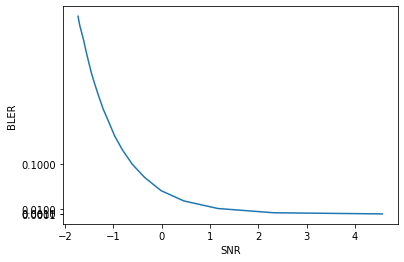

In [31]:
key,value = zip(*sorted(bler.items()))
plt.xlabel("SNR")
plt.ylabel("BLER")
plt.yticks([1e-4,1e-3,1e-2,1e-1,1.0])
plt.plot(key,value);

In [21]:
bler

{4.569619513137056: tensor(0.0002),
 2.3196195131370554: tensor(0.0025),
 1.1642141077316501: tensor(0.0110),
 0.4609238609631423: tensor(0.0262),
 -0.012198668681126179: tensor(0.0469),
 -0.3522554868629446: tensor(0.0733),
 -0.6084626786437666: tensor(0.0998),
 -0.8084292673507496: tensor(0.1280),
 -0.9688420253244829: tensor(0.1557),
 -1.1003804868629445: tensor(0.1857),
 -1.2101970006244125: tensor(0.2104),
 -1.303261842795148: tensor(0.2362),
 -1.3831363923747557: tensor(0.2601),
 -1.4524393103923563: tensor(0.2820),
 -1.5131391075525997: tensor(0.3056),
 -1.5667441232265809: tensor(0.3272),
 -1.6144295666175457: tensor(0.3480),
 -1.6571246729094562: tensor(0.3641),
 -1.6955738570286902: tensor(0.3782),
 -1.7303804868629447: tensor(0.3964)}